In [1]:
#IMPORTING SHIT
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt


import scipy
import scipy.signal
from scipy import signal
from scipy.io.wavfile import write
from scipy.io.wavfile import read
from scipy.signal import lfilter

from os.path import dirname, join as pjoin


import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

import wave

import colorednoise as cn
#from matplotlib import pylab as plt

import sounddevice as sd

from tqdm import tqdm
import time

import pathlib
from util.util import load_data_json, to_db
from expr.analysis import load_analysis

import hr.pam as pam
import hr.process as pierre

from scipy.optimize import curve_fit

%matplotlib widget

> ## Signal Synthesis

> Simple Noisless Signal with Two Sinusoids

In [181]:
N_synth = 63

f0_synth = 1/4
f_synth = np.array([f0_synth, f0_synth+(1/N_synth)])

a_synth = np.array([1, 10])

delta_synth = np.array([0, -0.05])

phi_synth = np.array([1.5, 0.5])

# synthesised signal
x_synth = pam.synthesize(N_synth, delta_synth, f_synth, a_synth, phi_synth)

plt.plot(np.real(x_synth[0]))

#np.max(np.real(x_synth))

> Simple Noisless Signal with One Sinusoid and Vibrato Effect

In [397]:
N_vibr0 = 2**11-1

delta_vibr0 = np.array([0])

f_vibr0 = np.array([0.44])

a_vibr0 = np.array([1])

phi_vibr0 = np.array([0])

f_m_vibr0 = 0.002
mod_index_vibr0 = 5

vibrato0 = pam.synthesize(N_vibr0, delta_vibr0, f_vibr0, a_vibr0, phi_vibr0, f_m_vibr0, mod_index_vibr0, 0, 0)

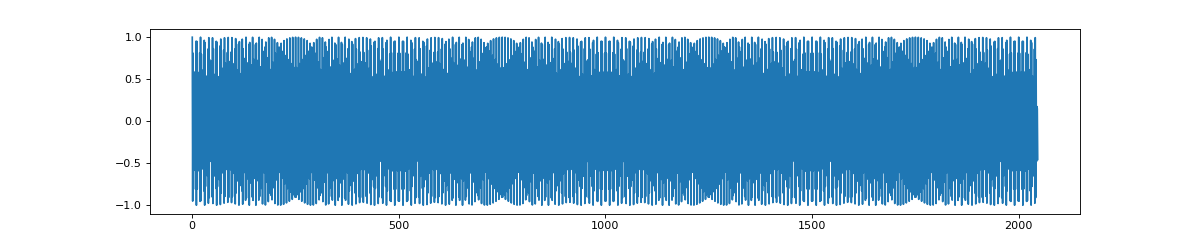

In [398]:
plt.figure(figsize=(15, 3), dpi=80)

plt.plot(np.real(vibrato0[0]))
plt.show()


In [399]:
fs_vibr0 = 1000

sd.play(np.real(vibrato0[0]), fs_vibr0)

print("The length of the signal is", N_vibr0/fs_vibr0, "seconds.")

t = np.linspace(0., N_vibr0/fs_vibr0, fs_vibr0)
amplitude = np.iinfo(np.int16).max
data  = amplitude*np.real(vibrato0[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("vibrato.wav", fs_vibr0, data.astype(np.int16))

The length of the signal is 2.047 seconds.


In [400]:
f_delta_vibr0 = mod_index_vibr0*f_m_vibr0*fs_vibr0
f_delta_vibr0

10.0

> Noisless Signal with Eight Sinusoids and vibrato Effect

In [185]:
N_vibr1 = 2**11-1

K_vibr1 = 8

f0_vibr1 = 0.06
f_vibr1 = f0_vibr1*np.arange(1,K_vibr1+1)

a_vibr1 = np.array([0.00807193, 0.09748246, 0.02404544, 0.04275309, 0.02482811,
       0.08778044, 0.00470351, 0.03118916])

delta_vibr1 = -0.0001*np.random.rand(K_vibr1)

phi_vibr1 = np.array([1.76348603, 1.20411769, 0.76158339, 1.35157899, 0.36247392,
       1.44086579, 1.73647764, 1.98131046])

vibrato1 = pam.synthesize(N_vibr1, delta_vibr1, f_vibr1, a_vibr1, phi_vibr1, 0.003, 10, 0, 0)

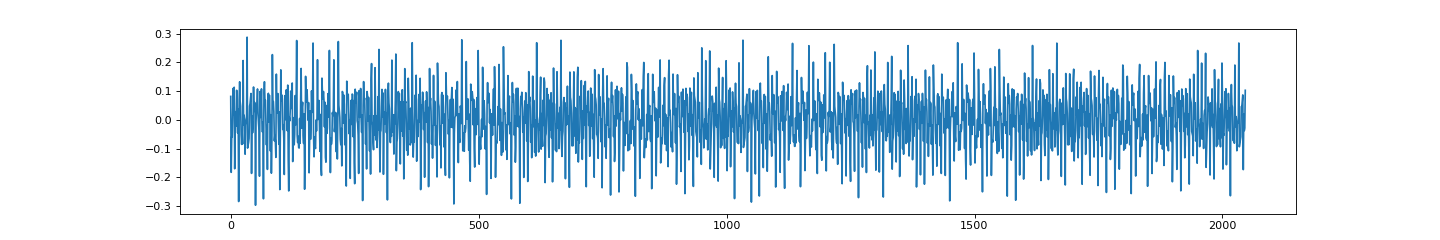

In [186]:
plt.figure(figsize=(18, 3), dpi=80)

plt.plot(np.real(vibrato1[0]))

plt.show()

In [187]:
fs_vibr1 = 1000

sd.play(np.real(vibrato1[0]), fs_vibr1)

print("The length of the signal is", N_vibr1/fs_vibr1, "seconds.")

t = np.linspace(0., N_vibr0/fs_vibr1, fs_vibr1)
amplitude = np.iinfo(np.int16).max
data  = amplitude*np.real(vibrato1[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("vibrato.wav", fs_vibr1, data.astype(np.int16))

The length of the signal is 2.047 seconds.


> Noisless Signal with Eight Sinusoids

In [258]:
N_synth1 = 2**12-1

K_synth1 = 8

#f_synth2 = 0.48*np.random.rand(0,K_synth2) + 0.1*np.ones(K_synth2) 

#a_synth2 = 19*np.random.rand(0,K_synth2) + np.ones(K_synth2) 

f_synth1 = 0.05*np.arange(1,K_synth2+1)

a_synth1 = np.array([18, 15, 13, 11, 8, 5, 4, 3])

delta_synth1 = -0.002*np.ones([K_synth2])

phi_synth1 = np.array([0, 1.5, 0, 1, 0, 1.5, 0, 1])

# synthesised signal
x_synth1, _, _, _ = pam.synthesize(N_synth1, delta_synth1, f_synth1, a_synth1, phi_synth1)

In [259]:
# play signal 
fs_synth1 = 1000

sd.play(np.real(x_synth1), fs_synth1)

print("The length of the signal is", N_synth1/fs_synth1, "seconds.")

The length of the signal is 4.095 seconds.


> Noisy Signal with Eight Sinusoids (Pink Noise and SNR = 39 dB)

SNR = 38.80160065822292 dB


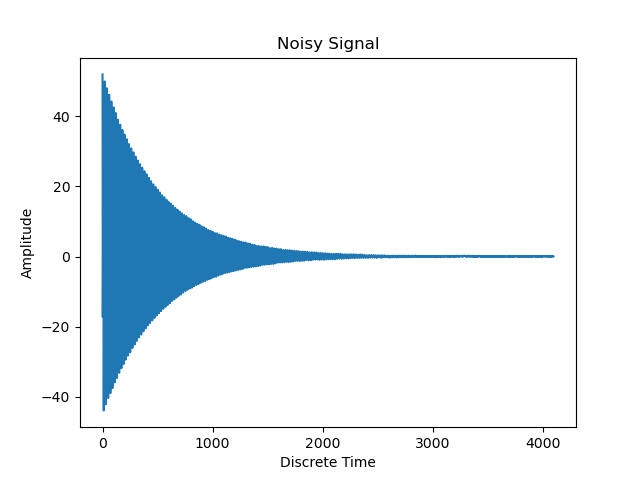

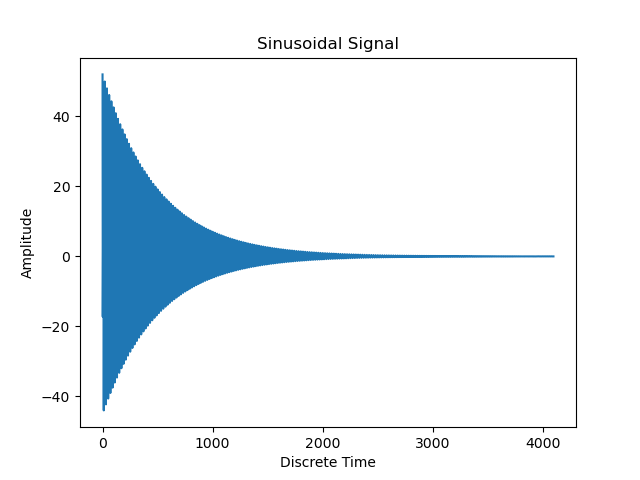

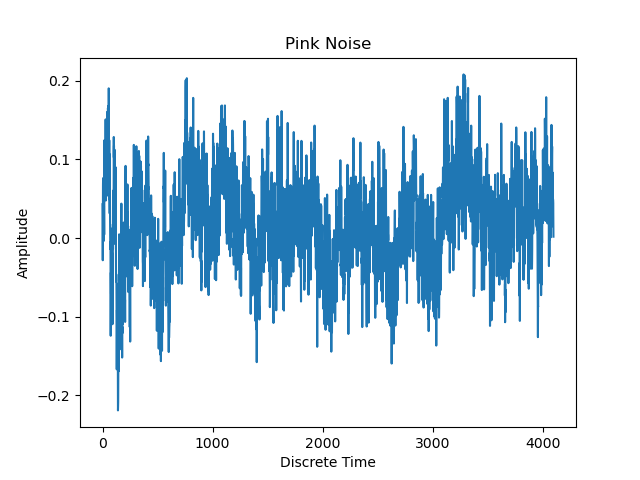

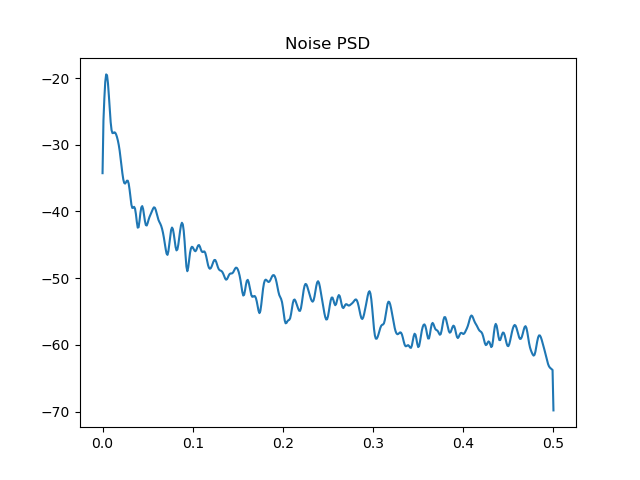

[0.00817789 0.00539863 0.00367687 0.00191048 0.00164109 0.00157111
 0.00096408 0.00120806]


In [290]:
N_synth2 = 2**12-1

K_synth2 = 8

#f_synth2 = 0.48*np.random.rand(0,K_synth2) + 0.1*np.ones(K_synth2) 

#a_synth2 = 19*np.random.rand(0,K_synth2) + np.ones(K_synth2) 

f_synth2 = 0.05*np.arange(1,K_synth2+1)

a_synth2 = np.array([18, 15, 13, 11, 8, 5, 4, 3])

delta_synth2 = -0.002*np.ones([K_synth2])

phi_synth2 = np.array([0, 1.5, 0, 1, 0, 1.5, 0, 1])

# synthesised signal
x_synth2, sin_synth2, noise_synth2, snr_synth2 = pam.synthesize(N_synth2, delta_synth2, f_synth2, a_synth2, phi_synth2, 0, 0, 2, 70)

print("SNR =", snr_synth2, "dB")

plt.figure()
plt.plot(np.real(x_synth2))
plt.title('Noisy Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(np.real(sin_synth2))
plt.title('Sinusoidal Signal')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
#plt.xlim(250,3000)
plt.show()

plt.figure()
plt.plot(noise_synth2)
plt.title('Pink Noise')
plt.xlabel('Discrete Time')
plt.ylabel('Amplitude')
plt.show()


plt.figure()
plt.title("Noise PSD")
freq_synth2, PSD_noise_synth2 = signal.welch(noise_synth2, nfft=1000)
plt.plot(freq_synth2, 20*np.log10(PSD_noise_synth2))
plt.show()

amp_noise2 = []
for i in range(1,9):
    amp_noise2.append(PSD_noise_synth2[i*50])
amp_noise2 = np.array(amp_noise2)
print(amp_noise2)

In [189]:
# play signal 
fs_synth2 = 1000

sd.play(np.real(x_synth2[0]), fs_synth2)

print("The length of the signal is", N_synth2/fs_synth2, "seconds.")

t = np.linspace(0., N_synth2/fs_synth2, fs_synth2)
amplitude = 0.01*np.iinfo(np.int16).max
data  = amplitude*np.real(x_synth2[0])

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("noisy2.wav", fs_synth2, data.astype(np.int16))

The length of the signal is 4.095 seconds.


> ## Loading Experimental Data

C:\Users\royal\anaconda3\envs\env_pam_hr\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 512 is greater than input length  = 80, using nperseg = 80
  warnings.warn('nperseg = {0:d} is greater than input length '


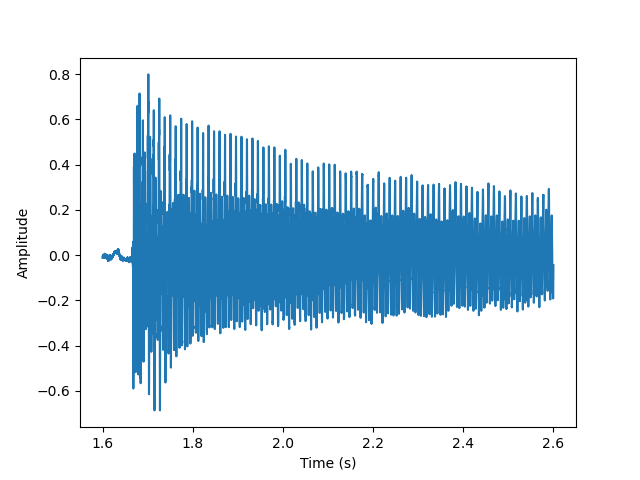

The length of the signal is 0.99998046875 seconds.


In [101]:
# Loading config from config files
conf_dir = pathlib.Path('./config/expr/')
data_dir = pathlib.Path('../data/expr/2022_01_27')
#
log_path = conf_dir / 'log_config.json'
conf_path = conf_dir / 'analysis_config.json'

# data_path = data_dir / 'MuteGuitar_HammerBridge_1.mat'
# data_path = data_dir / 'FirstStringGuitar_CopperWired01mm_5cm_1.mat'
# data_path = data_dir / 'FirstStringGuitar_CopperWired01mm_5cmFromBridge_2.mat'
# data_path = data_dir / 'FirstStringGuitar_CopperWired01mm_18cmFromBridge_1.mat'
# data_path = data_dir / 'FirstStringGuitar_CopperWired01mm_FifthFret_1.mat'
# data_path = data_dir / 'FirstStringGuitar_CopperWired005mm_5cmFromBridge_1.mat'
data_path = data_dir / 'FirstStringGuitar_CopperWired005mm_18cmFromBridge_1.mat'
# data_path = data_dir / 'FirstStringGuitar_CopperWired005mm_FifthFret_1.mat'
# data_path = data_dir / 'MuteGuitar_HammerBridge_1.mat'



log = load_data_json(log_path)
conf = load_data_json(conf_path)
expr_data = load_analysis(data_path, conf)

fs_mic = 51200
s0 = int(fs_mic*1.6)
s1 = int(fs_mic*2.6)

# see expr/util.py for details on what's inside expr_data
mic0 = expr_data["temporal"]["mic"]["whole"][s0:s1]
times = expr_data["times"]["whole"][s0:s1]

plt.figure()
#plt.title("Temporel Recorded Acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
#plt.xlim(0.7, 1.5)
#plt.ylim(-10, 10)
plt.plot(times, mic0)
plt.show()

print("The length of the signal is", times[-1]-times[0], "seconds.")

#plt.savefig('temporel_acc.svg', facecolor="none", transparent=True, format="svg")

In [12]:
# play signal
#fs_mic = int(1/(times[1]-times[0]))

sd.play(mic0, fs_mic)


#t = np.linspace(0., N_vibr0/fs_mic, fs_mic)
#amplitude = np.iinfo(np.int16).max
#data  = 0.1*amplitude*np.real(mi0c)

# UNCOMMENT TO WRITE A NEW WAV FILE
# write("mic.wav", fs_mic, data.astype(np.int16))

In [13]:
fs_mic

51200

(50000,)

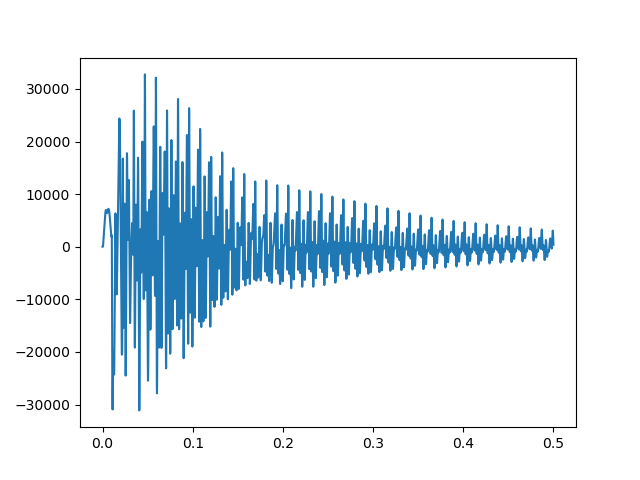

In [14]:
#uk_dir = 'C:\Users\royal\Desktop\HP\PAM\atiam_pam_hrparam\data\synth_uk\'
#file_name = pjoin(uk_dir, 'lowE_uk.wav')

file_name = r'C:\Users\royal\Desktop\HP\PAM\atiam_pam_hrparam\data\synth_uk\lowE_uk0.wav'

fs_uk, synth_uk = read(file_name)

length_uk = synth_uk.shape[0] / fs_uk

times_uk = np.linspace(0., length_uk, synth_uk.shape[0])

plt.figure()

plt.plot(times_uk, synth_uk)

synth_uk.shape


In [15]:
# play signal

sd.play(synth_uk, fs_uk)


> ## Signal Treatment

In [102]:
mic, freq_pre, PSD_mic, PSD_mic_pre = pam.preemphasize(mic0)

[]

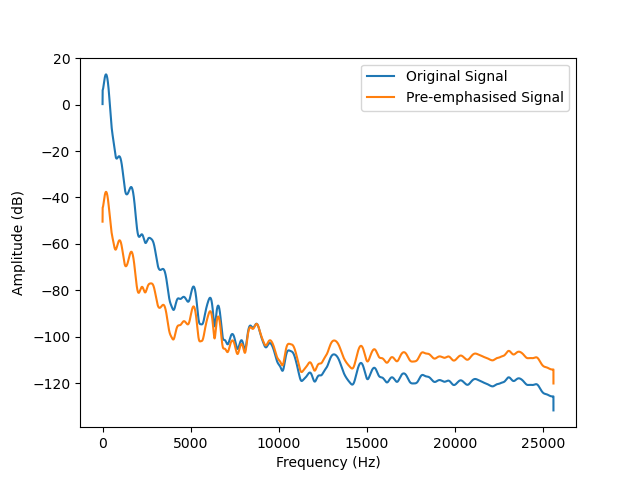

In [213]:
plt.figure()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.title('PSD before pre-emphasis')
plt.plot(freq_pre*fs_mic, 20*np.log10(PSD_mic), label="Original Signal")
plt.xlim()
#plt.savefig('PSD_beforepre_005mm_18cmFromBridge_1.svg', facecolor="none", transparent=True, format="svg")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.title('PSD after pre-emphasis')
plt.plot(freq_pre*fs_mic, 20*np.log10(PSD_mic_pre), label="Pre-emphasised Signal")
plt.legend()
#plt.savefig('PSD_preemph_005mm_18cmFromBridge_1.svg', facecolor="none", transparent=True, format="svg")
plt.plot()

> Constructing the Filter Bank

In [104]:
fs_mic
fs_uk

99999

10


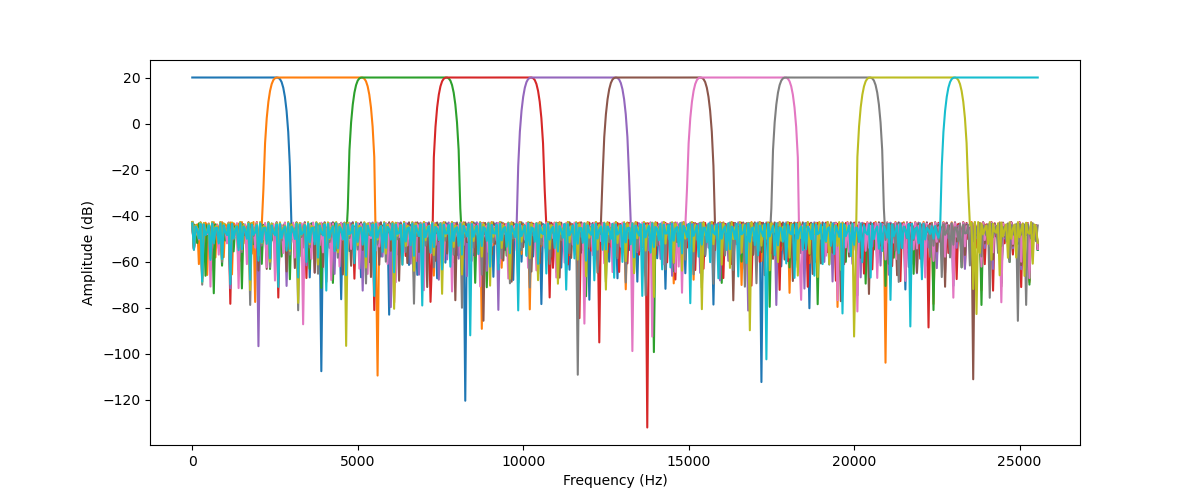

In [105]:
num_bands = 10

bank_coeffs = pam.filter_bank(num_bands, fs_mic, 425, 425)

print(len(bank_coeffs))

plt.figure(figsize=[12,5])

for i in range(len(bank_coeffs)):
    
    freqs, amps = signal.freqz(bank_coeffs[i], [1])
    plt.plot(0.5*fs_mic*freqs/np.pi, 20*np.log10(np.abs(amps)))
    
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')

#plt.savefig('filter_bank.svg', facecolor="none", transparent=True, format="svg")
plt.show()

20


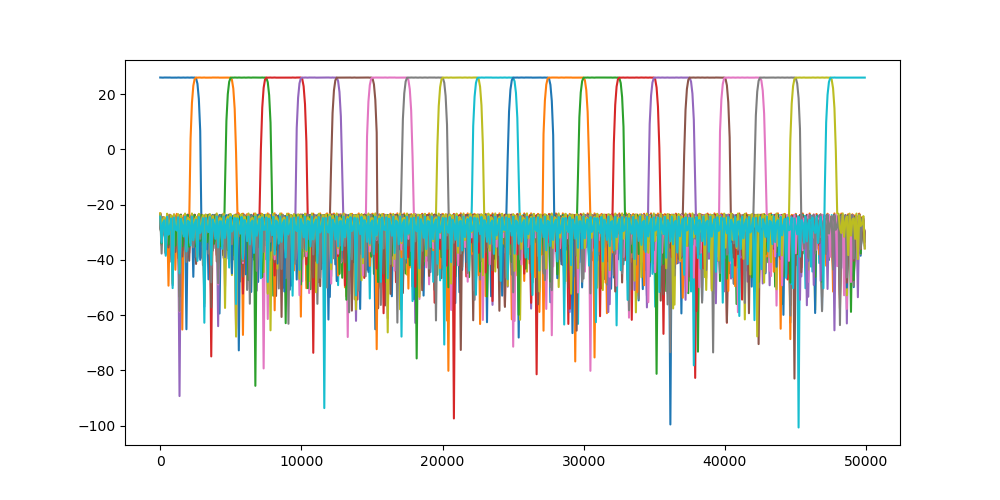

In [106]:
bank_coeffs_uk = pam.filter_bank(20, fs_uk, 625, 425)

print(len(bank_coeffs_uk))

plt.figure(figsize=[10,5])

for i in range(len(bank_coeffs_uk)):
    
    freqs, amps = signal.freqz(bank_coeffs_uk[i], [1])
    plt.plot(0.5*fs_uk*freqs/np.pi, 20*np.log10(np.abs(amps)))
    

plt.show()

> Filtering Signal with the Filter Bank and Decimation

In [107]:

mic_bands = []

for i in range(num_bands):
    # band filtering
    filtered = signal.lfilter(bank_coeffs[i], [1], mic)
    # frequency shifting
    N = filtered.shape[0]
    time = np.arange(0, N, dtype=complex)
    freq0 = 0.5*(i/num_bands)
    shifted = filtered*np.exp(2*np.pi*1j*freq0*time)
    # decimating
    decimated = pam.decimate(shifted, num_bands)
    decimated = np.real(decimated)
    mic_bands.append(decimated)
    

In [108]:
mic_bands[0].shape

(5120,)

In [109]:
# Filtering UK
num_bands_uk = len(bank_coeffs_uk)
uk_bands = []

for i in range(num_bands_uk):
    filtered = signal.lfilter(bank_coeffs_uk[i], [1], synth_uk)
    decimated = pam.decimate(filtered, num_bands_uk)
    uk_bands.append(decimated)

fs_bands_uk = fs_uk//num_bands_uk

> PSD of Signal by Sub-bands

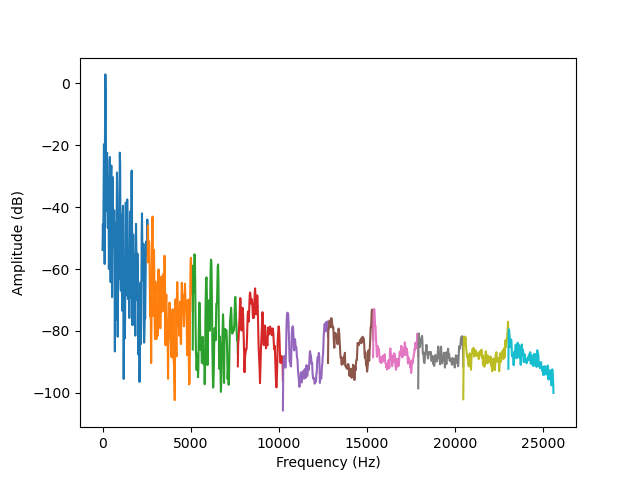

In [110]:
fs_bands = fs_mic//num_bands
plt.figure()
for i in range(num_bands):
    
    freqs, PSD = signal.welch(mic_bands[i])
    plt.plot(fs_bands*freqs+i*fs_bands/2, 20*np.log10(PSD))
    #plt.title('PSD by Sub-bands')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')

    #plt.savefig('PSD_bands.svg', facecolor="none", transparent=True, format="svg")

    #freqso, amps = signal.freqz(bank_coeffs[i], [1])
    #plt.plot(0.5*fs_mic*freqso/np.pi, 20*np.log10(np.abs(amps)))
plt.show()

#for i in range(num_bands):    
#    fft = np.fft.fft(mic_bands[i])
#    freqs = np.fft.fftfreq(mic_bands[i].size)
#    plt.figure()
#    plt.plot(freqs*fs_bands, np.abs(fft))
#    plt.show()

In [111]:
# play one sub-band
sd.play(mic_bands[0], fs_bands)

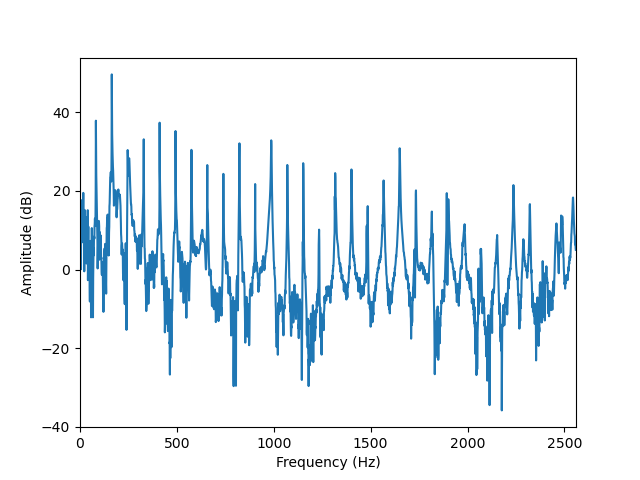

In [112]:
fft = np.fft.fft(mic_bands[0])
freqs = np.fft.fftfreq(mic_bands[0].size)
plt.figure()
plt.plot(np.fft.fftshift(freqs)*fs_bands, 20*np.log10(np.fft.fftshift(np.abs(fft))))
plt.xlim(0, 2560)
#plt.ylim(10, 10**4)
#plt.title('Periodogram')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.show()

#plt.savefig('fft_acc_lowband.svg', facecolor="none", transparent=True, format="svg")

> #### Noise Whitening

> Testing with Synthetic Signal

[0.00176973 0.00099831 0.00048218 ... 0.00029049 0.00048218 0.00099831]
The minimum value for the smoothing order is 131.136


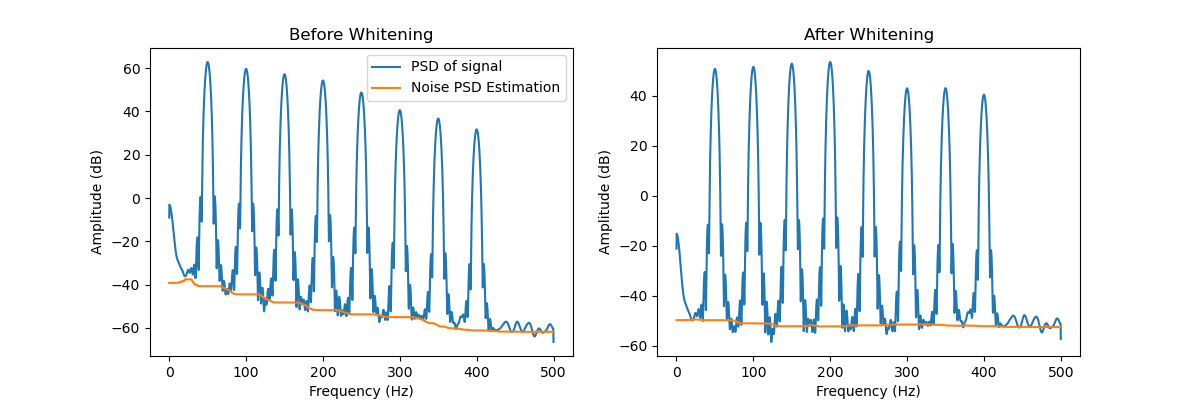

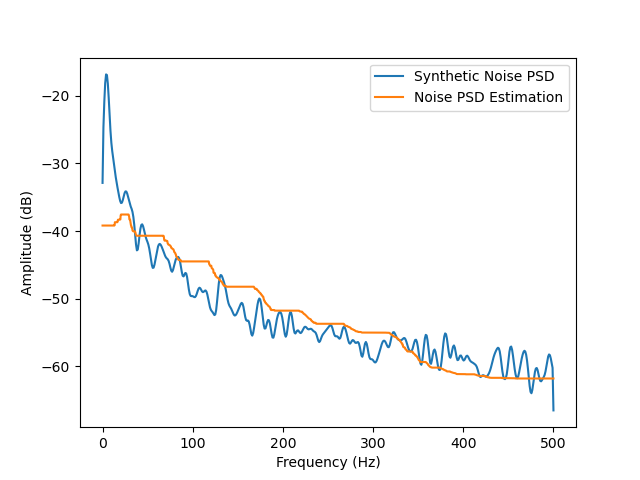

In [225]:
x_white2, freq2_norm, PSD_x2, PSD_noise2, PSD_x_white2, PSD_noise_white2, AR_coeffs2 = pam.whiten(np.real(x_synth2[0]), 800, 8, 15)

print('The minimum value for the smoothing order is', 4*0.016*len(freq2_norm))

freq2 = fs_synth2*freq2_norm

plt.figure(figsize=[12,4])
plt.subplot(1, 2, 1)

plt.title('Before Whitening')
plt.plot(freq2, 20*np.log10((PSD_x2)), label = 'PSD of signal')
plt.plot(freq2, 20*np.log10((PSD_noise2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()

plt.subplot(1, 2, 2)

plt.title('After Whitening')
plt.plot(freq2, 20*np.log10((PSD_x_white2)), label = 'PSD of signal')
plt.plot(freq2, 20*np.log10((PSD_noise_white2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.legend()
plt.show()


plt.figure()
#plt.title("Noise PSD")
plt.plot(fs_synth2*freq_synth2, 20*np.log10(PSD_noise_synth2), label = 'Synthetic Noise PSD')
plt.plot(freq2, 20*np.log10((PSD_noise2)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.show()

> Whitening the Experimental Signal (before filter bank)

In [114]:
'''
mic_white, freq_mic, PSD_mic, PSD_noise_mic, PSD_mic_white, PSD_noise_mic_white = pam.whiten(mic, 100, 4, 15)

print('The smoothing order must be at least', 4*0.016*len(freq_mic))

freq_mic *= fs_mic

plt.figure()
plt.title('Original Signal - Before Whitening')
plt.plot(freq_mic, 20*np.log10((PSD_mic)), label = 'PSD of signal')
plt.plot(freq_mic, 20*np.log10((PSD_noise_mic)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,500)
plt.legend()
plt.show()

plt.figure()
plt.title('Original Signal - After Whitening')
plt.plot(freq_mic, 20*np.log10((PSD_mic_white)), label = 'PSD of signal')
plt.plot(freq_mic, 20*np.log10((PSD_noise_mic_white)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,1000)
plt.legend()
plt.show()
'''

"\nmic_white, freq_mic, PSD_mic, PSD_noise_mic, PSD_mic_white, PSD_noise_mic_white = pam.whiten(mic, 100, 4, 15)\n\nprint('The smoothing order must be at least', 4*0.016*len(freq_mic))\n\nfreq_mic *= fs_mic\n\nplt.figure()\nplt.title('Original Signal - Before Whitening')\nplt.plot(freq_mic, 20*np.log10((PSD_mic)), label = 'PSD of signal')\nplt.plot(freq_mic, 20*np.log10((PSD_noise_mic)), label = 'Noise PSD Estimation')\nplt.xlabel('Frequency (Hz)')\nplt.ylabel('Amplitude (dB)')\n#plt.xlim(0,500)\nplt.legend()\nplt.show()\n\nplt.figure()\nplt.title('Original Signal - After Whitening')\nplt.plot(freq_mic, 20*np.log10((PSD_mic_white)), label = 'PSD of signal')\nplt.plot(freq_mic, 20*np.log10((PSD_noise_mic_white)), label = 'Noise PSD Estimation')\nplt.xlabel('Frequency (Hz)')\nplt.ylabel('Amplitude (dB)')\n#plt.xlim(0,1000)\nplt.legend()\nplt.show()\n"

> Whitening the First Band

[0.00049796 0.00033286 0.00021996 ... 0.0001385  0.00021996 0.00033286]
The smoothing order must be at least 262.208


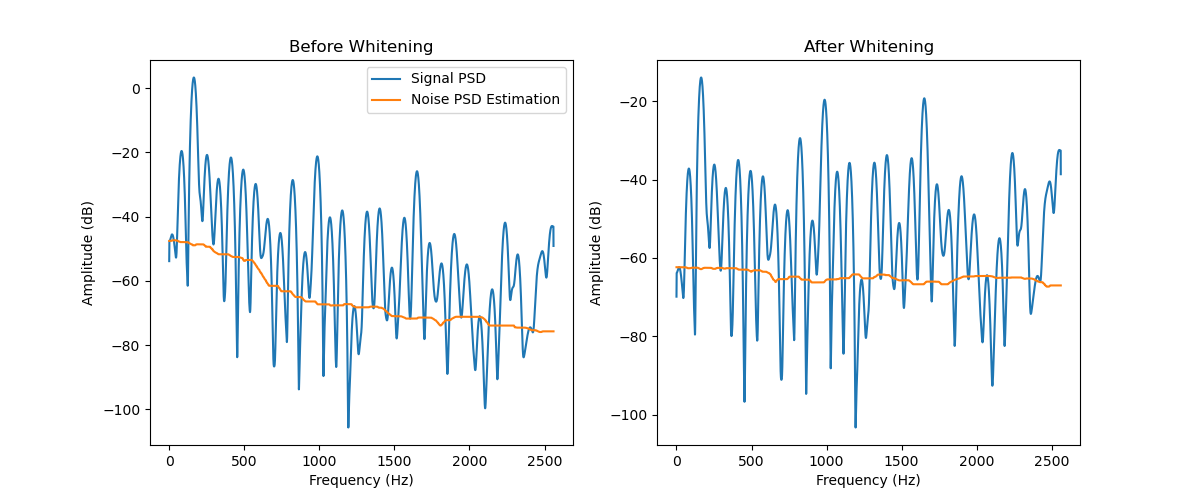

In [217]:
band0_white, freq_band0, PSD_band0, PSD_noise_band0, PSD_band0_white, PSD_noise_band0_white, AR_band0_white = pam.whiten(mic_bands[0], 2000, 4, 15)

print('The smoothing order must be at least', 4*0.016*len(freq_band0))

freq_band0 *= fs_bands

plt.figure(figsize=[12,5])

plt.subplot(1, 2, 1)

plt.title('Before Whitening')
plt.plot(freq_band0, 20*np.log10((PSD_band0)), label = 'Signal PSD')
plt.plot(freq_band0, 20*np.log10((PSD_noise_band0)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,1000)
plt.legend()
#plt.savefig('1stband_c_005mm_18cmFromBridge_1.svg', facecolor="none", transparent=True, format="svg")


plt.subplot(1, 2, 2)
plt.title('After Whitening')
plt.plot(freq_band0, 20*np.log10((PSD_band0_white)), label = 'Signal PSD')
plt.plot(freq_band0, 20*np.log10((PSD_noise_band0_white)), label = 'Noise PSD Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
#plt.xlim(0,1000)
#plt.legend()
#plt.savefig('whiten_005mm_18cmFromBridge_1.svg', facecolor="none", transparent=True, format="svg")
plt.show()

> ## HR Analysis

> Testing EPRIT and LeastSquares

In [271]:
#FOR x_synth1

delta_an1, f_an1 = pam.esprit(x_synth1, 32, 16)

alpha_an1, a_an1, phi_an1 = pam.least_squares(x_synth1, delta_an1, f_an1)

graph_s1 = np.array([f_an1, a_an1, delta_an1, phi_an1])

graph_s1 = graph_s1[:, graph_s1[0, :].argsort()]

start1 = 7
freq_roy1 = graph_s1[0][start1:]
freq_roy_hz1 = freq_roy1*fs_synth1
amp_roy1 = graph_s1[1][start1:]
delta_roy1 = graph_s1[2][start1:]
phi_roy1 = graph_s1[3][start1:]
#alpha_roy1 = graph_s1[4][8:]

print('nus\n', freq_roy1)
print('freqs\n', freq_roy_hz1)
print('amps\n', amp_roy1)
#print('alphas\n', alpha_roy1)
print('deltas\n', delta_roy1)
print('phis\n', phi_roy1)



nus
 [0.05       0.1        0.15       0.2        0.21699607 0.25
 0.3        0.35       0.4       ]
freqs
 [ 50.         100.         150.         200.         216.99607345
 250.         300.         350.         400.        ]
amps
 [1.80000000e+01 1.50000000e+01 1.30000000e+01 1.10000000e+01
 3.10070968e-11 8.00000000e+00 5.00000000e+00 4.00000000e+00
 3.00000000e+00]
deltas
 [-0.002      -0.002      -0.002      -0.002      -0.28130812 -0.002
 -0.002      -0.002      -0.002     ]
phis
 [-1.52896600e-13  1.50000000e+00 -1.99302113e-13  1.00000000e+00
  6.41263982e-01  1.14976388e-13  1.50000000e+00  2.37809772e-13
  1.00000000e+00]


In [252]:
#FOR x_synth2

delta_an, f_an = pam.esprit(x_white2, 36, 16)

alpha_an, a_an, phi_an = pam.least_squares(x_white2, delta_an, f_an)

graph_s = np.array([f_an, a_an, delta_an, phi_an, alpha_an])

graph_s = graph_s[:, graph_s[0, :].argsort()]

freq_roy = graph_s[0][8:]
freq_roy_hz = freq_roy*fs_synth2
amp_roy = graph_s[1][8:]
delta_roy = graph_s[2][8:]
phi_roy = graph_s[3][8:]
alpha_roy = graph_s[4][8:]

print('nus\n', freq_roy)
print('freqs\n', freq_roy_hz)
print('amps\n', amp_roy)
print('alphas\n', alpha_roy)
print('deltas\n', delta_roy)
print('phis\n', phi_roy)


nus
 [0.05004522+0.j 0.10008253+0.j 0.15004521+0.j 0.20008666+0.j
 0.25004277+0.j 0.30016103+0.j 0.35003606+0.j 0.4001796 +0.j]
freqs
 [ 50.04522352+0.j 100.08253276+0.j 150.045211  +0.j 200.08666135+0.j
 250.04277057+0.j 300.16103375+0.j 350.0360624 +0.j 400.1796019 +0.j]
amps
 [5.15783407+0.j 4.3900519 +0.j 5.789741  +0.j 5.36770754+0.j
 4.98483633+0.j 2.87491685+0.j 3.91171039+0.j 3.1202953 +0.j]
alphas
 [ 4.95510168+1.4318588j  -1.27379195+4.20119147j  5.08570653+2.76707246j
  0.76709596+5.31261217j  4.47723573+2.19156415j -0.41177923+2.84527411j
  3.46753148+1.81044294j  1.54309878+2.71202672j]
deltas
 [-0.00260581+0.j -0.00180866+0.j -0.0026039 +0.j -0.00211972+0.j
 -0.00269029+0.j -0.00212218+0.j -0.00368811+0.j -0.00327105+0.j]
phis
 [0.28130391+0.j 1.86518428+0.j 0.498293  +0.j 1.42739594+0.j
 0.45520468+0.j 1.71452234+0.j 0.48118104+0.j 1.05349527+0.j]


In [254]:
AR_coeffs2 = np.flip(AR_coeffs2)

zeds2 = np.exp(2*np.pi*1j*freq_roy)

dewhite_coeffs2 = np.polyval(AR_coeffs2, zeds2**(-1))
alpha_roy_dewhite = alpha_roy/dewhite_coeffs2

phi_roy_dewhite = np.angle(alpha_roy_dewhite)

print(phi_roy_dewhite)


[-1.24939337 -1.38335323  1.69770388  0.75201566 -2.16426427 -2.81554992
  0.3772629  -1.1432337 ]


> Testing ESPRIT by Blocks (with a vibrato)

In [422]:
window_length_vibr0 = 0.035
hop_size_vibr0 = 0.001

delta00, f00, alpha00, a00, phi00 = pam.esprit_blocks(vibrato0[0], window_length_vibr0, hop_size_vibr0, fs_vibr0, 32, 1)

num_blocks_vibr0 = len(f00)

print('- Damping factors:\n', delta00, '\n- Frequencies:\n', f00*fs_vibr0, '\n- Complex Amplitudes:\n', alpha00, '\n- Amplitudes:\n', a00, '\n- Intial Phases:\n', phi00 )

- Damping factors:
 [[-1.32742550e-06]
 [-1.46801788e-06]
 [-1.61551689e-06]
 ...
 [-2.83303471e-06]
 [-3.03207908e-06]
 [-3.23704208e-06]] 
- Frequencies:
 [[449.71004649]
 [449.68280973]
 [449.65404394]
 ...
 [449.4102825 ]
 [449.36946816]
 [449.32717426]] 
- Complex Amplitudes:
 [[ 0.99988941+0.0143481j ]
 [-0.95565047+0.2944738j ]
 [ 0.81839146-0.5746441j ]
 ...
 [ 0.94427802+0.32909037j]
 [-0.99974548-0.02161576j]
 [ 0.95758695-0.28806628j]] 
- Amplitudes:
 [[0.99999235]
 [0.99999131]
 [0.99999021]
 ...
 [0.99998072]
 [0.99997913]
 [0.99997748]] 
- Intial Phases:
 [[ 0.0143487 ]
 [ 2.84268512]
 [-0.61217609]
 ...
 [ 0.33534684]
 [-3.11997476]
 [-0.29221368]]


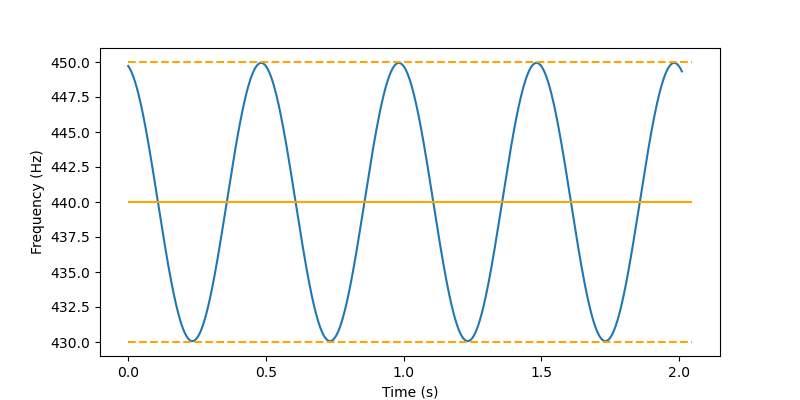

In [423]:
freq_vibr0 = np.zeros(len(f00))
for i in range(len(f00)):
    [f] = f00[i];
    freq_vibr0[i] = f

freq_vibr0

plt.figure(figsize=[8,4])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
blocks_vibr0 = np.arange(num_blocks_vibr0)
plt.plot(blocks_vibr0*hop_size_vibr0, freq_vibr0*fs_vibr0)

plt.hlines(440, 0, 2.047, 'orange')
plt.hlines(450, 0, 2.047, 'orange', 'dashed')
plt.hlines(430, 0, 2.047, 'orange', 'dashed')
plt.show()

In [31]:
delta00, f00, alpha00, a00, phi00 = pam.esprit_blocks(vibrato1[0][:200], 0.035, 0.020, fs_vibr1, 32, 8)

print('- Damping factors:\n', delta00, '\n- Frequencies:\n', f00*fs_vibr1, '\n- Complex Amplitudes:\n', alpha00, '\n- Amplitudes:\n', a00, '\n- Intial Phases:\n', phi00 )

- Damping factors:
 [[-3.84069579e-04 -6.16073582e-02 -9.85372893e-03 -2.17080615e-02
  -8.45269180e-01 -1.19126196e+00 -1.67684715e+00 -8.09297444e-01]
 [-2.46632374e-02 -1.52835153e-02  1.03806535e-02 -5.08783704e-02
  -1.10021717e+00 -1.52989943e+00 -1.45483395e+00 -1.63800991e+00]
 [ 6.83245737e-03 -2.42065609e-02 -1.98073286e-02 -7.48041297e-02
  -6.66994077e-01 -8.66507133e-01 -1.49845033e+00 -1.60469146e+00]
 [-1.72727595e-03 -6.89435823e-02 -2.03713081e-02 -2.42038444e-02
  -1.90077232e+00 -6.82139076e-01 -1.92403062e+00 -1.09776491e+00]
 [-6.98172951e-03 -1.35605356e-02 -9.43779136e-02 -2.83075973e-02
  -9.58683435e-01 -1.11178249e+00 -6.86970413e-01 -1.61856711e+00]
 [ 8.07999282e-03 -8.46355352e-02 -8.10853557e-03 -4.32028953e-02
  -5.44185571e-01 -1.00959091e+00 -8.67696146e-01 -1.41987768e+00]
 [ 8.34959494e-03 -2.70443966e-02 -7.15063200e-03 -1.80385361e-02
  -7.15034914e-01 -1.02482600e+00 -2.24765404e+00 -1.45481415e+00]
 [ 1.98435425e-03 -6.40035295e-02 -1.68388360e-02

> HR Analysis for Experimental Signal

In [32]:
delta_mic, f_mic, alpha_mic, a_mic, phi_mic = pam.esprit_blocks(mic_white, 0.030, 0.020, fs_mic, 32, 30)

print( 'Frequencies:\n', f_mic*fs_mic, '\n\n- Damping factors:\n', delta_mic, '\n\n- Complex Amplitudes:\n', alpha_mic, '\n\n- Amplitudes:\n', a_mic, '\n\n- Intial Phases:\n', phi_mic )

NameError: name 'mic_white' is not defined

In [33]:
# ESPRIT FOR synth_uk
window_length = 0.1
hop_size = 0.01

delta_uk, freq_uk, alpha_uk, amp_uk, phi_uk = pam.esprit_blocks(uk_bands[0], window_length, hop_size, fs_bands_uk, 68, 66)

freq_uk_hz = freq_uk*fs_bands_uk

print(freq_uk_hz.shape)

print( 'Frequencies:\n', freq_uk_hz) #, '\n\n- Damping factors:\n', delta_band0, '\n\n- Complex Amplitudes:\n', alpha_band0, '\n\n- Amplitudes:\n', amp_band0, '\n\n- Intial Phases:\n', phi_band0 )

(40, 66)
Frequencies:
 [[   73.99091267   -73.99091267   104.8892947  ...  2459.8469716
  -2459.8469716   2499.5       ]
 [ 2461.65307796 -2461.65307796  2376.84210294 ...   -74.25867846
    176.45197961  -176.45197961]
 [ 2499.5         2397.10567941 -2397.10567941 ...   107.10050501
   -107.10050501     0.        ]
 ...
 [   81.56457222   -81.56457222   163.39612552 ...  2499.5
   2420.37144574 -2420.37144574]
 [   81.56709203   -81.56709203   163.40556316 ... -2294.94256803
   2204.74464595 -2204.74464595]
 [   81.56777828   -81.56777828   163.39880834 ... -2304.04184114
   2104.02656817 -2104.02656817]]


In [34]:


#band0_white_n = int(2*window_length*fs_mic/5)



In [116]:
band0_white_n = 68

band0_white_order_pmax = band0_white_n//2

band0_white_order = pierre.Ester.estimate_esm_ordre(band0_white, band0_white_n, band0_white_order_pmax)

band0_white_order

6

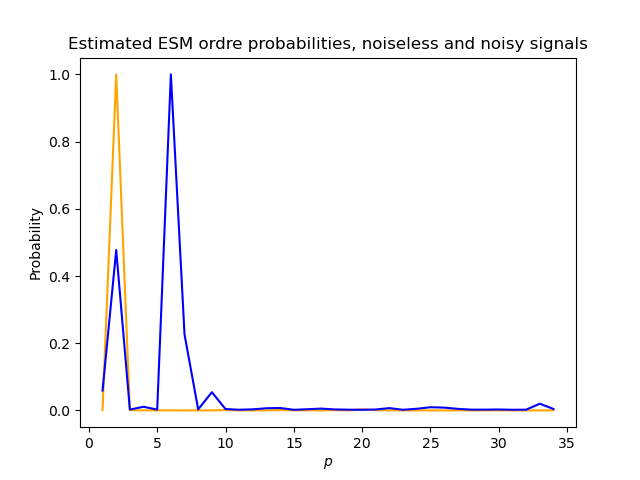

Ordre of the ESM model
 Noisy=2, Whitened=6


In [117]:
ps = np.arange(1,band0_white_order_pmax+1)
#j_sine = Ester.inverse_error_func(x_sine, n=n_est, p_max=p_max)
j_noise = pierre.Ester.inverse_error_func(mic_bands[0], n=band0_white_n, p_max=band0_white_order_pmax)
j_white = pierre.Ester.inverse_error_func(band0_white, n=band0_white_n, p_max=band0_white_order_pmax)

plt.figure()
plt.title('Estimated ESM ordre probabilities, noiseless and noisy signals')
plt.xlabel('$p$')
plt.ylabel('Probability')
#plt.plot(ps, j_sine/np.max(j_sine), c='cyan')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='b')
plt.show()

#r_est_sine = Ester.estimate_esm_ordre(x_sine, n_est, p_max)
r_est_noise = pierre.Ester.estimate_esm_ordre(mic_bands[0], n=band0_white_n, p_max=band0_white_order_pmax)
r_est_white = pierre.Ester.estimate_esm_ordre(band0_white, n=band0_white_n, p_max=band0_white_order_pmax)
print('Ordre of the ESM model')
print(f' Noisy={r_est_noise}, Whitened={r_est_white}')

In [146]:
window_length = 0.5
hop_size = 0.05

delta_band0, freq_band0, alpha_band0, amp_band0, phi_band0 = pam.esprit_blocks(band0_white, window_length, hop_size, fs_bands, 68, 2*32)

freq_band0_hz = freq_band0*fs_bands
print(freq_band0_hz.shape)

print( 'Frequencies:\n', freq_band0_hz) #, '\n\n- Damping factors:\n', delta_band0, '\n\n- Complex Amplitudes:\n', alpha_band0, '\n\n- Amplitudes:\n', amp_band0, '\n\n- Intial Phases:\n', phi_band0 )

(10, 64)
Frequencies:
 [[ 2541.46051849 -2541.46051849  2471.83201296 -2471.83201296
   2238.17167043 -2238.17167043  2316.40524192 -2316.40524192
   2396.63272539 -2396.63272539  2156.38167217 -2156.38167217
   1980.06188995 -1980.06188995  1899.93166184 -1899.93166184
   1813.35869658 -1813.35869658  1735.05854237 -1735.05854237
   1650.59845182 -1650.59845182  1699.35237446 -1699.35237446
   1566.57461218 -1566.57461218  1484.34386862 -1484.34386862
   1401.79051409 -1401.79051409  1319.03952448 -1319.03952448
   1152.21556131 -1152.21556131  1069.24096418 -1069.24096418
    986.46127134  -986.46127134   165.04458051  -165.04458051
     74.19842657   -74.19842657    95.06083767   -95.06083767
    250.02346228  -250.02346228   324.54776732  -324.54776732
    410.39215047  -410.39215047   493.4542928   -493.4542928
    578.58780987  -578.58780987   651.96809375  -651.96809375
    741.41844286  -741.41844286   823.23482177  -823.23482177
    916.37030651  -916.37030651  1017.56916785 -

frequencies
 [  19.19272058   82.20471146  164.16471291  245.5928585   328.85808723
  411.09923809  493.18351673  575.49430216  657.10760958  739.97136373
  822.64610494  904.29427601  987.34784937 1070.20168436 1152.38543418
 1234.22095444 1317.16965487 1401.41691349 1484.04093061 1566.26191227
 1650.21355688 1733.50276431 1816.9536669  1894.13299837 1964.93765507
 2029.50278063 2060.28367624 2236.70118452 2321.36810403 2398.49802225
 2480.40663415 2535.03009327]
amplitudes
 [0.0005585  0.00792376 0.02813561 0.00616838 0.0069457  0.0088795
 0.00797311 0.00574433 0.00434528 0.00520352 0.01355192 0.00333148
 0.02138357 0.00828282 0.01022443 0.00232042 0.00693674 0.01224077
 0.00274874 0.00570555 0.020653   0.00659392 0.00485564 0.00192136
 0.00057937 0.00029653 0.00081203 0.00687564 0.00508475 0.00035018
 0.00111698 0.00328328]
damping factors
 [-2.44662646e-04 -1.37773540e-04 -1.03440993e-04 -7.86929052e-04
 -4.03518530e-04 -1.60701461e-04 -2.30433397e-04  8.06084677e-06
 -2.47096562e-

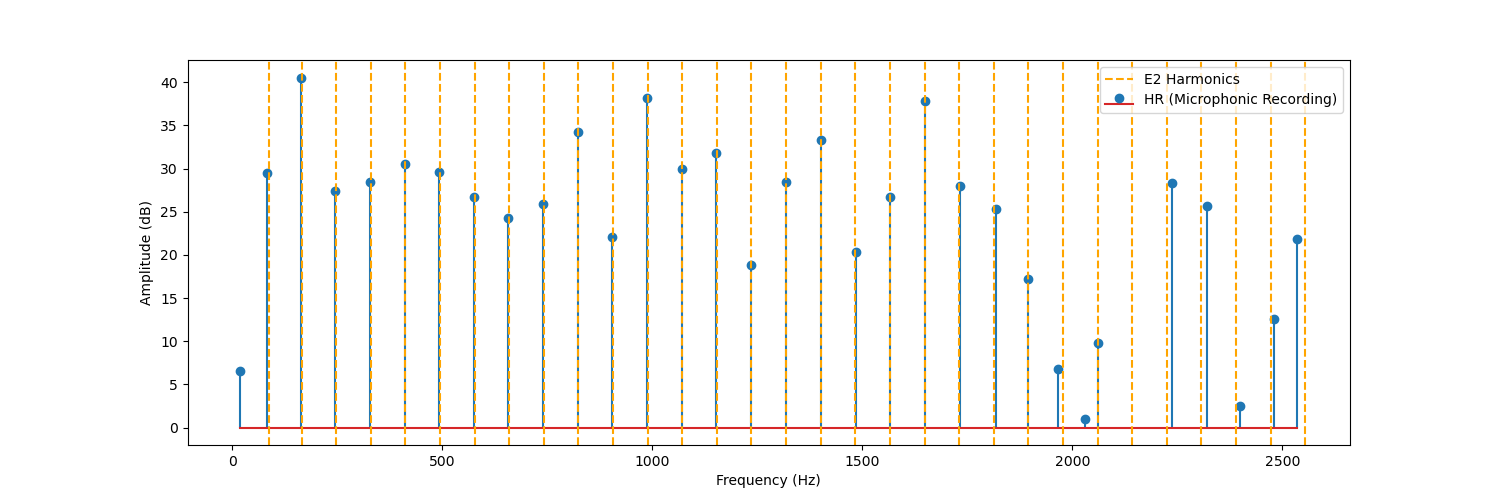

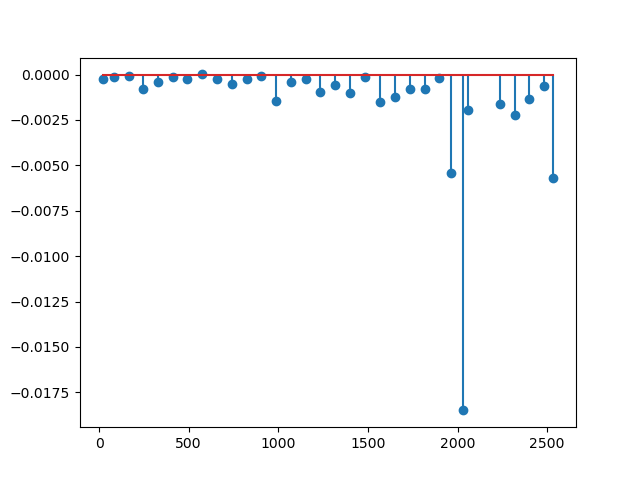

In [147]:
block = 5

graph = np.array([freq_band0_hz[block], amp_band0[block], delta_band0[block], phi_band0[block]]) #alpha_band0[block]

graph = graph[:, graph[0, :].argsort()]

start = freq_band0_hz.shape[1]//2 


freqs_alex = graph[0][start:] #freq
nus_alex = freqs_alex/fs_bands
amps_log = np.abs(np.min(20*np.log10(graph[1][start:]))) + 20*np.log10(graph[1][start:]) + 1 #amp log

amps_alex = graph[1][start:]
damping_alex = graph[2][start:] #damping
phases_alex = graph[3][start:]
#complex_alex = graph[4][start:]

graph_uk = np.array([freq_uk_hz[block], amp_uk[block]])

graph_uk = graph_uk[:, graph_uk[0, :].argsort()]

start_uk = freq_uk_hz.shape[1]//2 - 1

x_uk = graph_uk[0][start_uk:]
y_uk = np.abs(np.min(20*np.log10(graph_uk[1][start_uk:]))) + 20*np.log10(graph_uk[1][start_uk:]) + 1
y_uk = 0.4*y_uk

print('frequencies\n', freqs_alex)
print('amplitudes\n', amps_alex)
print('damping factors\n', damping_alex)
print('initial phases\n', phases_alex)
#print('complex amplitudes\n', complex_alex)

#print(x_uk)

plt.figure(figsize = [15,5])

#plt.title('Frequencies detected by ESPRIT for a block of ' + str(window_length*1000) + ' ms\n(' + str(block*hop_size*1000) + ' ms after attack).')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')


plt.stem(freqs_alex, amps_log, label='HR (Microphonic Recording)')


#plt.setp(markerline, markersize = 5)

#plt.stem(x_uk[:], 0.8*y_uk[:], 'g', markerfmt='Dg',  label='HR (UK synthesis)')


plt.axvline(88.4, 0, 1, color='orange', linestyle='dashed', label='E2 Harmonics')
for i in range(2,32):
    plt.axvline(i*82.4, 0, 1, color='orange', linestyle='dashed')

plt.legend(loc = 'upper right')

#plt.savefig('comparison.svg', facecolor="none", transparent=True, format="svg")
plt.show()

plt.figure()
plt.stem(freqs_alex, damping_alex, label='HR Analysis')
plt.show()

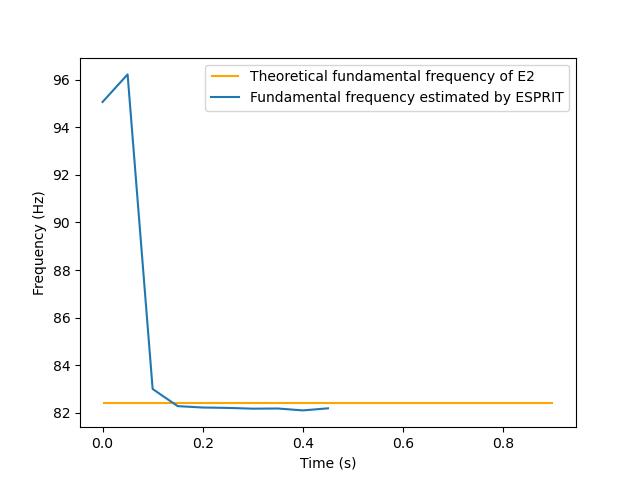

In [148]:
num_block = len(delta_band0)
fundamental = 82.4

freqs_fund = []

for block in range(num_block):

    graph = np.array([freq_band0_hz[block], amp_band0[block], delta_band0[block], phi_band0[block]]) #alpha_band0[block]
    graph = graph[:, graph[0, :].argsort()]
    freqs_all = graph[0]
    
    if block < num_block//6:
        threshold = 0
    else:
        threshold = -5

    freq0 = min(freq for freq in freqs_all - fundamental if freq > threshold)
    i0 = np.where(freqs_all == freq0 + fundamental)
    freqs_fund.append(freqs_all[i0])


plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
blocks = np.arange(num_block)
plt.hlines(82.4, 0, 0.9, 'orange', label='Theoretical fundamental frequency of E2')
plt.plot(hop_size*blocks, freqs_fund, label='Fundamental frequency estimated by ESPRIT')
plt.legend()
plt.show()
#plt.savefig('fundamental.svg', facecolor="none", transparent=True, format="svg")
   

In [149]:
nus_alex

array([0.00374858, 0.01605561, 0.03206342, 0.04796736, 0.0642301 ,
       0.08029282, 0.09632491, 0.11240123, 0.12834133, 0.14452566,
       0.16067307, 0.17661998, 0.19284138, 0.20902377, 0.22507528,
       0.24105878, 0.2572597 , 0.27371424, 0.28985174, 0.30591053,
       0.32230734, 0.33857476, 0.35487376, 0.36994785, 0.38377689,
       0.39638726, 0.40239916, 0.4368557 , 0.45339221, 0.46845664,
       0.48445442, 0.49512307])

In [150]:
AR_band0_white = np.flip(AR_band0_white)

zeds = np.exp(2*np.pi*1j*nus_alex)

dewhite_coeffs = np.polyval(AR_band0_white, zeds**(-1))
amps_alex_dewhite = amps_alex/np.abs(dewhite_coeffs)

np.abs(dewhite_coeffs)


array([0.36781313, 0.36304819, 0.37067648, 0.40992391, 0.44929576,
       0.46285994, 0.48968722, 0.58395579, 0.72301841, 0.85455851,
       0.954489  , 1.03294344, 1.09881154, 1.13814313, 1.14530166,
       1.14467366, 1.17254824, 1.23892976, 1.32026796, 1.39872028,
       1.46485429, 1.49776151, 1.48136816, 1.43689221, 1.41141042,
       1.4303694 , 1.45469977, 1.6471833 , 1.71203245, 1.76151612,
       1.80605042, 1.82225448])

In [151]:
print(amps_alex)
print(amps_alex_dewhite)

[0.0005585  0.00792376 0.02813561 0.00616838 0.0069457  0.0088795
 0.00797311 0.00574433 0.00434528 0.00520352 0.01355192 0.00333148
 0.02138357 0.00828282 0.01022443 0.00232042 0.00693674 0.01224077
 0.00274874 0.00570555 0.020653   0.00659392 0.00485564 0.00192136
 0.00057937 0.00029653 0.00081203 0.00687564 0.00508475 0.00035018
 0.00111698 0.00328328]
[0.00151842 0.02182563 0.07590342 0.01504762 0.01545907 0.019184
 0.01628205 0.00983693 0.00600992 0.00608913 0.01419808 0.00322523
 0.01946064 0.00727748 0.00892728 0.00202715 0.00591596 0.00988011
 0.00208196 0.00407912 0.01409901 0.00440252 0.00327781 0.00133716
 0.00041049 0.00020731 0.00055821 0.00417418 0.00297001 0.0001988
 0.00061847 0.00180177]


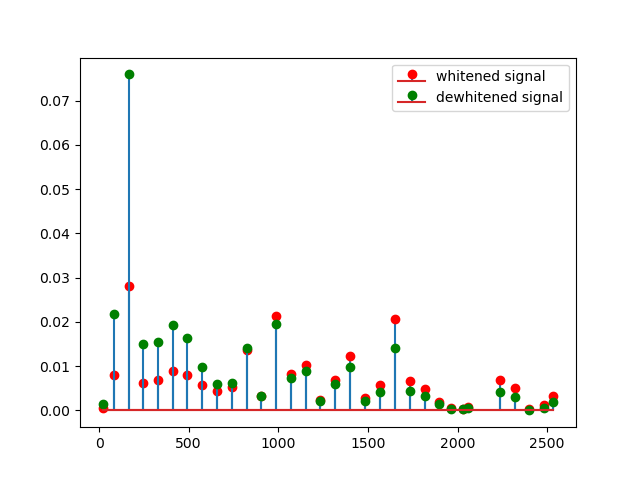

In [152]:
plt.figure()
plt.stem(freqs_alex, amps_alex, markerfmt='ro', label='whitened signal')
plt.stem(freqs_alex, amps_alex_dewhite, markerfmt='go', label='dewhitened signal')
plt.legend()
plt.show()

In [153]:
damp_acc = np.array([-0.01270824, -0.00470592, -0.00454763, -0.00187058, -0.00478688, -0.00282691, -0.00382689, -0.0108937, -0.00989453])
modal_mass = np.array([2.91, 0.45, 0.25, 2.65, 9.88, 0.41, 0.38, 1.07, 2.33])

In [154]:
c_n = -2*modal_mass*damp_acc*fs_bands
c_n

array([378.68521882,  21.68487936,  11.6419328 ,  50.76005888,
       484.29439386,  11.86849894,  14.89119437, 119.36009216,
       236.07557018])

In [291]:
freqs_study = freqs_alex[1:24]
n_x = np.arange(len(freqs_study)) + 1
freqs_y = freqs_study / (n_x)
freqs_study

array([  82.20471146,  164.16471291,  245.5928585 ,  328.85808723,
        411.09923809,  493.18351673,  575.49430216,  657.10760958,
        739.97136373,  822.64610494,  904.29427601,  987.34784937,
       1070.20168436, 1152.38543418, 1234.22095444, 1317.16965487,
       1401.41691349, 1484.04093061, 1566.26191227, 1650.21355688,
       1733.50276431, 1816.9536669 , 1894.13299837])

In [292]:
def fit_func(n, a2):
    # Curve fitting function
    return a2 * n**2 + freqs_study[0]  # a1=0, a0=1

In [297]:
[a2], covar = curve_fit(fit_func, n_x, freqs_y)
n_fit = np.linspace(n_x[0], n_x[-1], 100)
y_fit = a2 * n_fit**2 + freqs_study[0]


a_2 = 0.00060564218


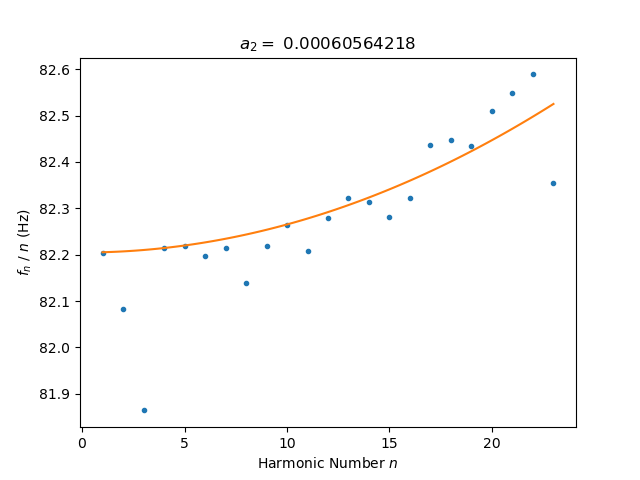

In [298]:
print('a_2 = ' + str(round(a2, 11)))
plt.figure()

plt.plot(n_x, freqs_y, '.')         # Data
plt.plot(n_fit, y_fit)  # Fitted curve
plt.title('$a_2 =$ ' + str(round(a2, 11)))
plt.xlabel("Harmonic Number $n$")
plt.ylabel("$f_n$ / $n$ (Hz)")

#plt.savefig('quad2000_025_05_68_32_005mm_18cmFromBridge_1.svg', facecolor="none", transparent=True, format="svg")
plt.show()

In [301]:
s_d = np.sqrt(np.diag(covar))
s_d


array([8.20363529e-05])

In [159]:
freqs_lin = freqs_alex[1:12]
n_lin = np.arange(len(freqs_lin)) + 1
freqs_lin_y = freqs_lin / n_lin

In [165]:
L = 0.651

def fit_lin(n, c):
    # Curve fitting function
    return c/(2*L)

In [166]:
params1 = curve_fit(fit_lin, n_lin, freqs_lin_y)
[c] = params1[0]
n_fit1 = np.linspace(n_lin[0], n_lin[-1], 100)
y_fit1 = 0 * n_fit1 + c/(2*L)


In [175]:
2*0.641*82.41

105.64962

c = 106.98026 m/s
rho = 0.00552kg/m
T = 63.13unit
The fundemental freq 82.1661018798279


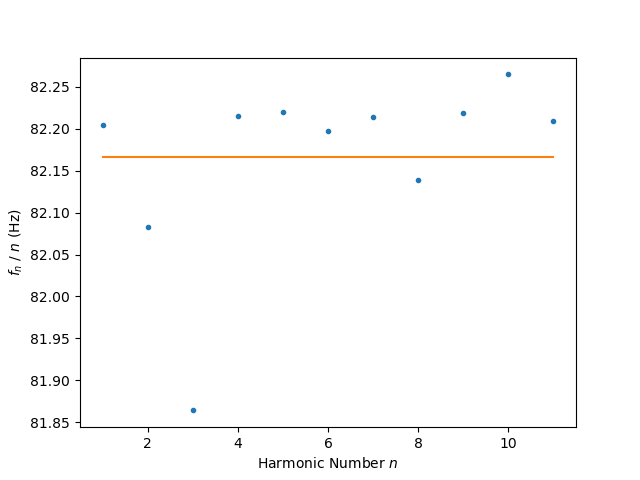

In [179]:
print('c = ' + str(round(c, 5)) + ' m/s')
rho = 5.02*10**(-3) / 0.91
print('rho = ' + str(round(rho, 5)) + 'kg/m')
tension = rho*c**2
print('T = ' + str(round(tension, 2)) + 'unit')
print('The fundemental freq ' + str(c/(2*L)))

plt.figure()

plt.plot(n_lin, freqs_lin_y, '.')
plt.plot(n_fit1, y_fit1)  # Fitted curve
#plt.title('$c =$ ' + str(round(c, 1)) + ' m/s')

plt.xlabel("Harmonic Number $n$")
plt.ylabel("$f_n$ / $n$ (Hz)")

#plt.savefig('lin2000_025_05_68_32_005mm_18cmFromBridge_1.svg', facecolor="none", transparent=True, format="svg")
plt.show()

In [171]:
B = 2*tension*(L**2)*a2 / (np.pi**2*freqs_study[0])
B

3.994673549118887e-05

In [164]:
fs_bands

5120

In [447]:
fs_bands*0.05

256.0

In [114]:
# pre-emphasize
mic_pre, freq_pre, PSD_mic, PSD_mic_pre = pam.preemphasize(mic0)
   
colored_list = []
white_list = []
freq_list = []
PSD_c_list = []
PSD_noise_c_list = []
PSD_w_list = []
PSD_noise_w_list = []
ESTER_orders = []
delta_list = []
freq_list = []
alpha_list = []
amp_list = []
phi_list = []
synth_list = []
synth_up_list = []

window_length = 0.05
hop_size = 0.05

mic0_length = len(mic0)  # the length of the signal (in samples)
block_length = int(window_length * fs_bands)  # window size (in samples)
h = int(hop_size * fs_bands)  # hop size (in samples)
num_blocks = int((mic0_length - block_length) / h)
total_length = block_length*num_bands*num_blocks
synth_final = np.zeros(48640)

for i in range(num_bands):

    # apply filter bank
    filtered = signal.lfilter(bank_coeffs[i], [1], mic_pre)
    # frequency shifting
    N = filtered.shape[0]
    time = np.arange(0, N, dtype=complex)
    freq0 = 0.5*(i/num_bands)
    shifted = filtered*np.exp(2*np.pi*1j*freq0*time)
    # decimating
    decimated = pam.decimate(shifted, num_bands)
    decimated = np.real(decimated)
    band_white, freq_band, PSD_band, PSD_noise_band, PSD_band_white, PSD_noise_band_white, AR_band_coeffs = pam.whiten(decimated, 2000, 4, 15)
    white_list.append(band_white)
    freq_list.append(freq_band)
    PSD_c_list.append(PSD_band)
    PSD_noise_c_list.append(PSD_noise_band)
    PSD_w_list.append(PSD_band_white)
    PSD_noise_w_list.append(PSD_noise_band_white)
    # ESTER
    n = 68
    p_max = n//2
    r = pierre.Ester.estimate_esm_ordre(band_white, n, p_max)
    ESTER_orders.append(r)
    # ESPRIT
    delta_band, freq_band, alpha_band, amp_band, phi_band = pam.esprit_blocks(band_white, window_length, hop_size, fs_bands, n, 2*r)
    # correcting amplitudes
    AR_band_coeffs = np.flip(AR_band_coeffs)
    zeds = np.exp(2*np.pi*1j*freq_band)
    dewhite_coeffs = np.polyval(AR_band_coeffs, zeds**(-1))
    amp_band = amp_band/np.abs(dewhite_coeffs)
    # re-shifting frequencies 
    freq_band += freq0
    # filling lists
    delta_list.append(delta_band)
    freq_list.append(freq_band)
    alpha_list.append(alpha_band)
    amp_list.append(amp_band)
    phi_list.append(phi_band)
    # synthesize
    synth_band = np.array([])
    for j in range(len(delta_band)):
        block, _, _, _ = pam.synthesize(block_length, delta_band[j], freq_band[j], amp_band[j], phi_band[j])
        synth_band = np.concatenate((synth_band, np.real(block)))
    synth_list.append(synth_band)
    # resample
    synth_band_up = signal.resample(synth_band, num_bands*len(synth_band))
    synth_up_list.append(synth_band_up)
    # add bands
    synth_band_up = np.array(synth_band_up)
    synth_final += synth_band_up

[0.00033539 0.00027326 0.00019975 ... 0.00014064 0.00019975 0.00027326]
[1.21043559e-05 3.83895878e-06 3.02890171e-06 ... 4.90191000e-07
 3.02890171e-06 3.83895878e-06]
[ 6.18666763e-06  8.89778676e-08  6.69722381e-07 ... -4.29303885e-07
  6.69722381e-07  8.89778676e-08]
[7.24354979e-06 1.56291038e-07 2.58157854e-07 ... 3.74913639e-08
 2.58157854e-07 1.56291038e-07]
[ 8.01904170e-06 -2.50812872e-07  3.75770921e-07 ...  9.93117502e-08
  3.75770921e-07 -2.50812872e-07]
[ 1.07765236e-05 -3.74243345e-07  2.79722364e-07 ... -1.84770536e-09
  2.79722364e-07 -3.74243345e-07]
[ 1.19786584e-05 -1.02749448e-07  1.50266338e-07 ... -6.27945253e-08
  1.50266338e-07 -1.02749448e-07]
[ 1.36546774e-05 -4.58656487e-07  2.27125418e-07 ... -1.44863644e-07
  2.27125418e-07 -4.58656487e-07]
[ 1.66994746e-05 -8.63488318e-07  6.53642010e-07 ... -2.95091244e-07
  6.53642010e-07 -8.63488318e-07]
[ 1.38923039e-05  2.49842234e-06 -1.04990521e-07 ...  1.84122114e-07
 -1.04990521e-07  2.49842234e-06]


In [115]:
print(ESTER_orders)

[34, 2, 7, 34, 34, 29, 1, 4, 1, 1]


In [167]:
synth_band_up.shape

(28160,)

In [168]:
256*11

2816

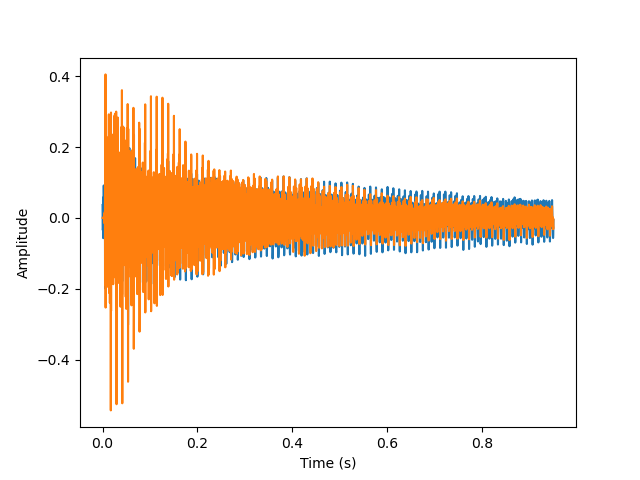

In [61]:
i = 0

length_sec = len(synth_list[i]) / fs_bands
times_synth = np.linspace(0., length_sec, len(synth_list[i]))

plt.figure()
plt.plot(times_synth, 0.5*synth_list[i])
plt.plot(times_synth, white_list[i][:4864])
 #white_list[i][:4864]- 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

sd.play(synth_list[i], fs_bands)

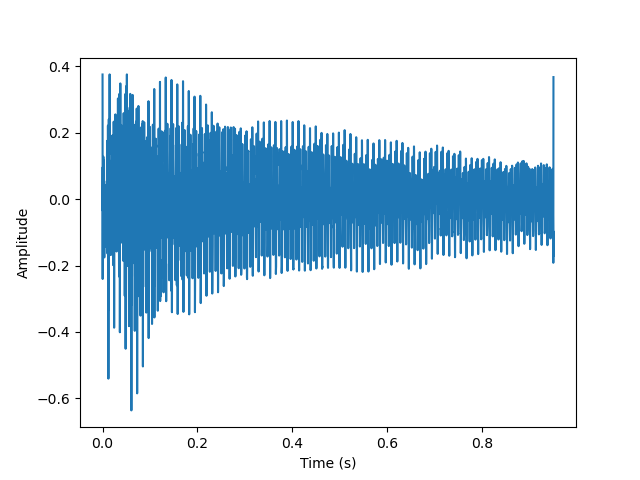

In [493]:
times_final = np.linspace(0., length_sec, len(synth_final))

plt.figure()
plt.plot(times_final, synth_final)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

sd.play(synth_final, fs_mic)

In [234]:
sd.play(mic, fs_mic)